## Preprocessing of imaging data
### Load, parse metadata and generate data object

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as ppatch
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari

#for roi generation
import shapely as sp
from shapely.geometry.polygon import LinearRing, Polygon, LineString

In [2]:
from fly2p.viz.viz import myAxisTheme

import fly2p.preproc.imgPreproc as imp

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

### Set paths to data files and plot directory

In [3]:
dataDir = '../../../../data/EPG/SS96_x_7f/f01'#'../sample' # dFB/84C10_x_7f/f02
rawTiff = 'SS96-x-7f_f01_3-5d_EB_2LM_00001.tif'#'84C10-x-7f_f02_4-5d_FB_dark_00001.tif'#'SS96_x_7f_25per_allProjectorsOn_00002.tif'
plotDir = sep.join([sep.join(dataDir.split(sep)[0:-2]), 'plot'])

print(dataDir)
print(plotDir)

../../../../data/EPG/SS96_x_7f/f01
../../../../data/EPG/plot


In [4]:
genotype = rawTiff.split('_')[0]
[flyID, age, region] = rawTiff.split('_')[1:4]
condition = rawTiff.split('_')[-2]
trial = rawTiff.split('_')[-1][:-4]
print(genotype, region, flyID, age, condition, trial)

SS96-x-7f EB f01 3-5d 2LM 00001


In [5]:
# Generate directory where to save plots
saveDir = sep.join([plotDir,genotype, condition])
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

../../../../data/EPG/plot/SS96-x-7f/2LM


### Load tiff file

#### Extract relevant information from header

In [6]:
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict

In [7]:
#with ScanImageTiffReader("data/resj_00001.tif") as reader:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))

metadat = mytiffreader.metadata()

basicMetadat = getSIbasicMetadata(metadat)

# give channel identity
basicMetadat["CaCh"] = 0
SImetadict = getSIMetadict(metadat)

#print(mytiffreader.metadata())

basicMetadat

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'
SI.hChannels.channelSave = 1


{'nCh': 1,
 'fpsscan': 38.1043,
 'discardFBFrames': 'false',
 'nDiscardFBFrames': 0,
 'fpv': 7,
 'nVols': 1400,
 'stackZStepSize': 9,
 'scanVolumeRate': 5.44347,
 'fovCoords': [array([-25.3125, -25.3125]),
  array([25.3125, 25.3125]),
  array([ 25.3125, -25.3125]),
  array([-25.3125,  25.3125])],
 'xrange_um': 50.625,
 'yrange_um': 50.625,
 'CaCh': 0}

#### Read and reshape image tiff stack

In [8]:
vol = mytiffreader.data()
volshape = vol.shape
print(volshape)

vol = vol.reshape((int(volshape[0]/(basicMetadat['fpv']*basicMetadat['nCh'])),
                   basicMetadat['fpv'],basicMetadat['nCh'],volshape[1], volshape[2]))

print('Full dimensional stack: volumes, planes, channels, xpix, ypix')
print(vol.shape)

stack = vol[:,0:basicMetadat['fpv']-basicMetadat['nDiscardFBFrames'],basicMetadat['CaCh'],:,:]
print('Stack reduced to one color channel and flyback frames discrded: stack4d')
print(stack.shape)

(9800, 200, 200)
Full dimensional stack: volumes, planes, channels, xpix, ypix
(1400, 7, 1, 200, 200)
Stack reduced to one color channel and flyback frames discrded: stack4d
(1400, 7, 200, 200)


In [9]:
import xarray as xr

# Note that this conversion + the shift to avoid values below 0 
# is packaged in preproc.imgPreproc by stack2xarray() in for convenience

volcoords = [i/basicMetadat['scanVolumeRate'] for i in range(stack.shape[0])]
slices = [i*basicMetadat['stackZStepSize'] for i in range(stack.shape[1])]
xpx = np.linspace(0, basicMetadat['xrange_um'], stack.shape[2])
ypx = np.linspace(0, basicMetadat['yrange_um'], stack.shape[3])
                  
imgStack = xr.DataArray(stack, coords = [volcoords, slices, xpx, ypx], 
                        dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])

imgStack

<xarray.DataArray (volumes [s]: 1400, planes [µm]: 7, xpix [µm]: 200, ypix [µm]: 200)>
array([[[[-33, -19, -11, ...,  -9, -17, -26],
         [ -7,  -7, -17, ...,   4,  -1,  -2],
         [ -7,  -2,   4, ..., -19, -18,  -5],
         ...,
         [-25, -23,  -9, ..., -10, -19, -23],
         [ -6,  -4, -21, ...,  -4,  -1,  -4],
         [ -8,   4,  -1, ..., -25, -17,  -2]],

        [[-14,  -4,   0, ..., -24, -27, -12],
         [-14, -25, -22, ...,  -2, -18, -10],
         [  0,   2,  -8, ..., -13,  -6,  -1],
         ...,
         [-14,  35,  21, ..., -25, -22, -17],
         [-16, -24, -22, ...,  -1,  -7, -12],
         [ -5,  -1, -12, ...,  -9,  -6,   3]],

        [[ -5,   8,  12, ..., -20, -13,  -6],
         [-29, -18, -12, ...,  -8, -22, -26],
         [ -4, -12, -23, ...,  -2,   8, -12],
         ...,
...
         ...,
         [ -8,  -9, -25, ...,   0,   7, -14],
         [ 42,   8,   1, ..., -20,  -9,  -4],
         [-29, -20, -13, ...,  -7,   8, -23]],

        [[-17, -27, -21, ...,  37,  -3, -19],
         [  1,  49,  17, ...,  -5,  -6,  25],
         [-15,  23,  48, ..., -28, -18, -15],
         ...,
         [ 37,  15,  32, ..., -12,  45, -24],
         [ -3,  -9, -14, ...,  -3,   8,  -6],
         [-12,  -5,   2, ..., -27, -15,  -5]],

        [[-17,  -5,  -5, ..., -16, -24,   7],
         [-13, -19, -26, ...,  30,   5, -16],
         [ -4,  -1, -10, ...,  -7,  -2,   2],
         ...,
         [ -6,  25,  -1, ...,  18,  12, -16],
         [ 49, -22, -22, ...,   5, -14, -18],
         [  5,  -1, -14, ..., -14,   3,   1]]]], dtype=int16)
Coordinates:
  * volumes [s]  (volumes [s]) float64 0.0 0.1837 0.3674 ... 256.6 256.8 257.0
  * planes [µm]  (planes [µm]) int64 0 9 18 27 36 45 54
  * xpix [µm]    (xpix [µm]) float64 0.0 0.2544 0.5088 ... 50.12 50.37 50.62
  * ypix [µm]    (ypix [µm]) float64 0.0 0.2544 0.5088 ... 50.12 50.37 50.62

Shift data to ensure no values are below 0

In [15]:
minval = np.min(imgStack)
if minval < 0: imgStack = imgStack - minval
    
imgStack

<xarray.DataArray (volumes [s]: 1400, planes [µm]: 7, xpix [µm]: 200, ypix [µm]: 200)>
array([[[[ 34,  48,  56, ...,  58,  50,  41],
         [ 60,  60,  50, ...,  71,  66,  65],
         [ 60,  65,  71, ...,  48,  49,  62],
         ...,
         [ 42,  44,  58, ...,  57,  48,  44],
         [ 61,  63,  46, ...,  63,  66,  63],
         [ 59,  71,  66, ...,  42,  50,  65]],

        [[ 53,  63,  67, ...,  43,  40,  55],
         [ 53,  42,  45, ...,  65,  49,  57],
         [ 67,  69,  59, ...,  54,  61,  66],
         ...,
         [ 53, 102,  88, ...,  42,  45,  50],
         [ 51,  43,  45, ...,  66,  60,  55],
         [ 62,  66,  55, ...,  58,  61,  70]],

        [[ 62,  75,  79, ...,  47,  54,  61],
         [ 38,  49,  55, ...,  59,  45,  41],
         [ 63,  55,  44, ...,  65,  75,  55],
         ...,
...
         ...,
         [ 59,  58,  42, ...,  67,  74,  53],
         [109,  75,  68, ...,  47,  58,  63],
         [ 38,  47,  54, ...,  60,  75,  44]],

        [[ 50,  40,  46, ..., 104,  64,  48],
         [ 68, 116,  84, ...,  62,  61,  92],
         [ 52,  90, 115, ...,  39,  49,  52],
         ...,
         [104,  82,  99, ...,  55, 112,  43],
         [ 64,  58,  53, ...,  64,  75,  61],
         [ 55,  62,  69, ...,  40,  52,  62]],

        [[ 50,  62,  62, ...,  51,  43,  74],
         [ 54,  48,  41, ...,  97,  72,  51],
         [ 63,  66,  57, ...,  60,  65,  69],
         ...,
         [ 61,  92,  66, ...,  85,  79,  51],
         [116,  45,  45, ...,  72,  53,  49],
         [ 72,  66,  53, ...,  53,  70,  68]]]], dtype=int16)
Coordinates:
  * volumes [s]  (volumes [s]) float64 0.0 0.1837 0.3674 ... 256.6 256.8 257.0
  * planes [µm]  (planes [µm]) int64 0 9 18 27 36 45 54
  * xpix [µm]    (xpix [µm]) float64 0.0 0.2544 0.5088 ... 50.12 50.37 50.62
  * ypix [µm]    (ypix [µm]) float64 0.0 0.2544 0.5088 ... 50.12 50.37 50.62

### Motion correction
#### Correct translation in x/y using phase correlation

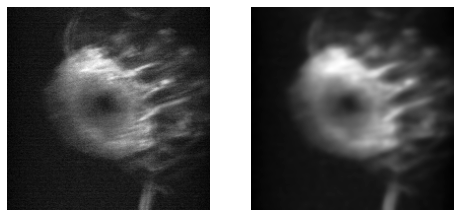

In [17]:
# Settings
## reference image
numRefImg = 600
locRefImg = round(stackMP['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower')
axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower')
axs[1].axis('off');

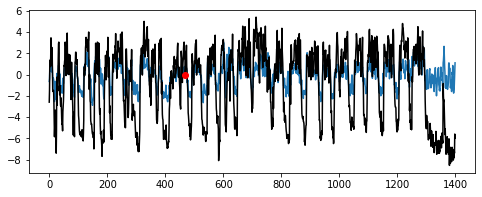

In [85]:
stackMPMC, shift = imp.motionCorrection(stackMP, refImg, 20, 2)

fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(shift[0,:])
ax.plot(shift[1,:],'k')
ax.plot(locRefImg,0,'ro')

#### Apply estimated motion to 4d stack
We assume here that all planes in a volume at a given time moved together

In [19]:
stack4dMC = imp.applyShiftTo4Dstack(imgStack, shift)

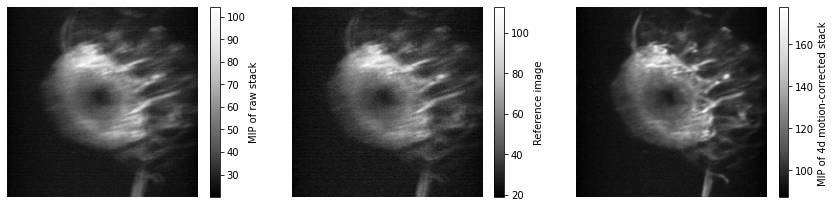

In [25]:
fig, axs = plt.subplots(1,3,figsize=(12,3))
cb = axs[0].imshow(stack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

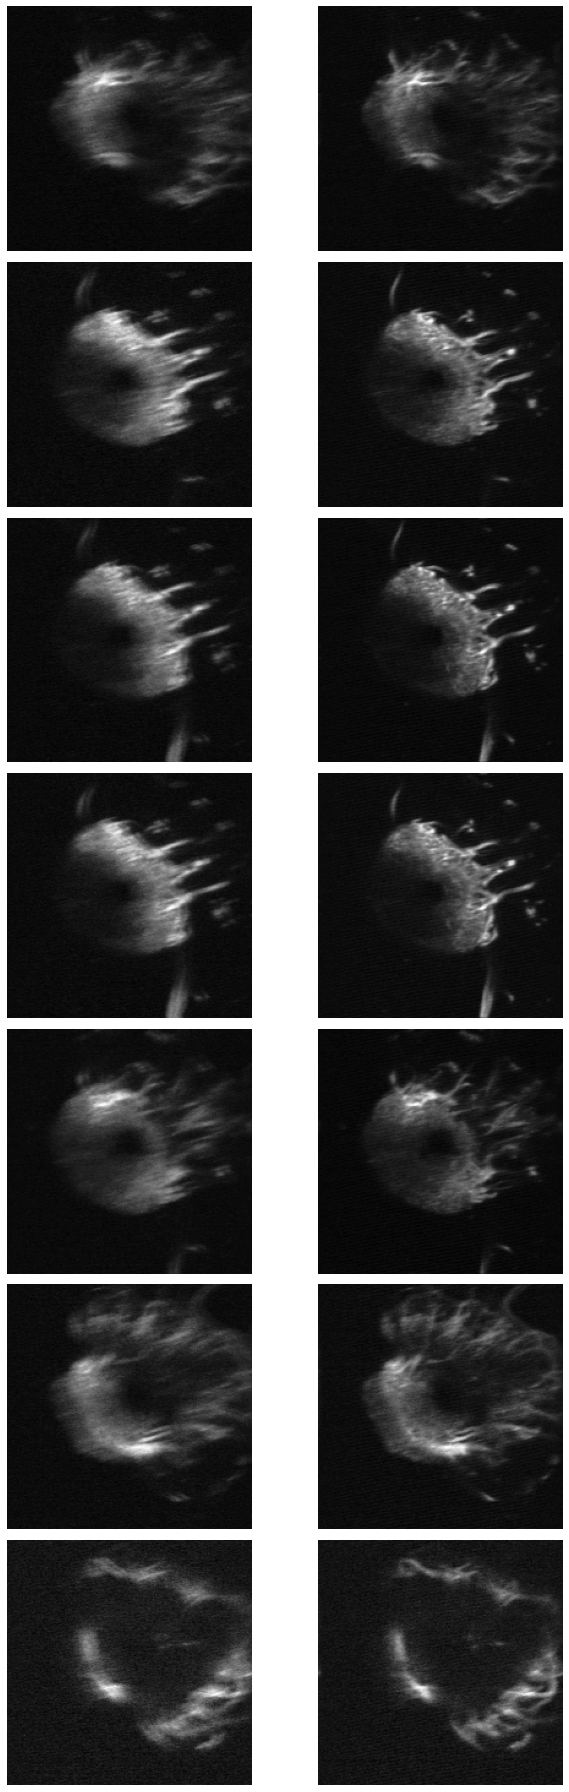

In [90]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2, figsize=(10, 25))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i,0].imshow(imgStack[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,1].imshow(stack4dMC[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,0].axis('off')
    ax[i,1].axis('off');
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['meanSignal_beforeAfterMC_',genotype, region, flyID, age, condition, trial])+'.pdf')

### Perform correlation analysis to get ROIs

#### (1) Compute DFF

In [35]:
# Settings
# filter DF/F trace with Savitzky-Golay filter
from scipy.signal import savgol_filter

# 3rd order, 7 frames
order = 3
window = 7

# Currently F_0 is estimated for the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

(a) one plane

In [36]:
dffStackMC = np.zeros((stackMPMC.shape)) 
stackF0 = np.zeros((stackMPMC["xpix [µm]"].size,stackMPMC["ypix [µm]"].size)) 

filtStack = gaussian_filter(stackMPMC, sigma=[0,2,2])

for x in range(stackMPMC["xpix [µm]"].size):
    for y in range(stackMPMC["ypix [µm]"].size):
            
        filtF = savgol_filter(filtStack[:,x,y], window, order)

        # Estimate baseline
        F0 = np.percentile(filtF, baseLinePercent)
        stackF0[x,y] = F0
        if F0 == 0: F0 += offset

        # Compute dF/F_0 = (F_raw - F_0)/F_0
        dFF = (filtF - F0) / F0

        dffStackMC[:,x,y] = dFF

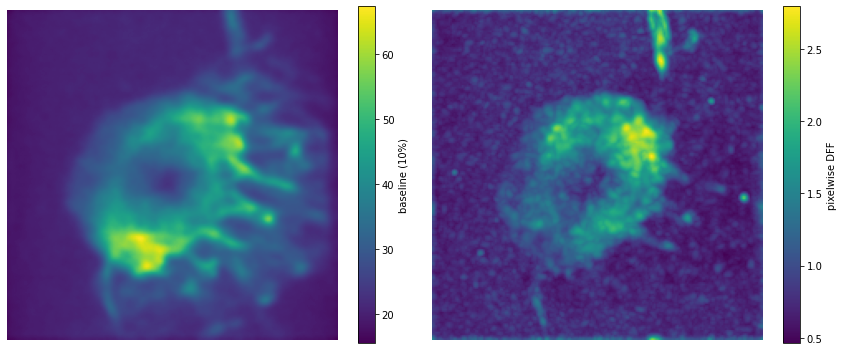

In [37]:
dffMP = np.max(dffStackMC,axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)

Volume

In [38]:
tmp = napari.view_image(filtStack)

In [39]:
tmpStk = np.zeros((stackMPMC["volumes [s]"].size,stackMPMC["xpix [µm]"].size, stackMPMC["ypix [µm]"].size)) 

for x in range(stack4dMC["xpix [µm]"].size):
    for y in range(stack4dMC["ypix [µm]"].size):

        tmpStk[:,x,y] = savgol_filter(filtStack[:,x,y], window, order)

In [40]:
tmp2 = napari.view_image(tmpStk)

(-0.5, 199.5, 199.5, -0.5)

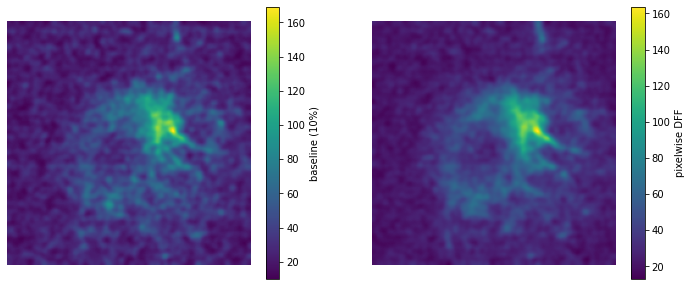

In [41]:
t = 10

fig, ax = plt.subplots(1,2,figsize=(12,5))
cb = ax[0].imshow(filtStack[t,:,:],cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(tmpStk[t,:,:],cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')

In [42]:
dffStack4dMC = np.zeros((stack4dMC.shape)) 
stackF0 = np.zeros((stack4dMC["planes [µm]"].size, stackMPMC["xpix [µm]"].size, stackMPMC["ypix [µm]"].size)) 

for p in range(stack4dMC["planes [µm]"].size):
    filtStack = gaussian_filter(stack4dMC[{'planes [µm]': p}].squeeze(), sigma=[0,2,2])

    for x in range(stack4dMC["xpix [µm]"].size):
        for y in range(stack4dMC["ypix [µm]"].size):

            filtF = savgol_filter(filtStack[:,x,y], window, order)

            # Estimate baseline
            F0 = np.percentile(filtF, baseLinePercent)
            stackF0[p,x,y] = F0
            if F0 == 0: F0 += offset

            # Compute dF/F_0 = (F_raw - F_0)/F_0
            dFF = (filtF - F0) / F0

            dffStack4dMC[:,p,x,y] = dFF

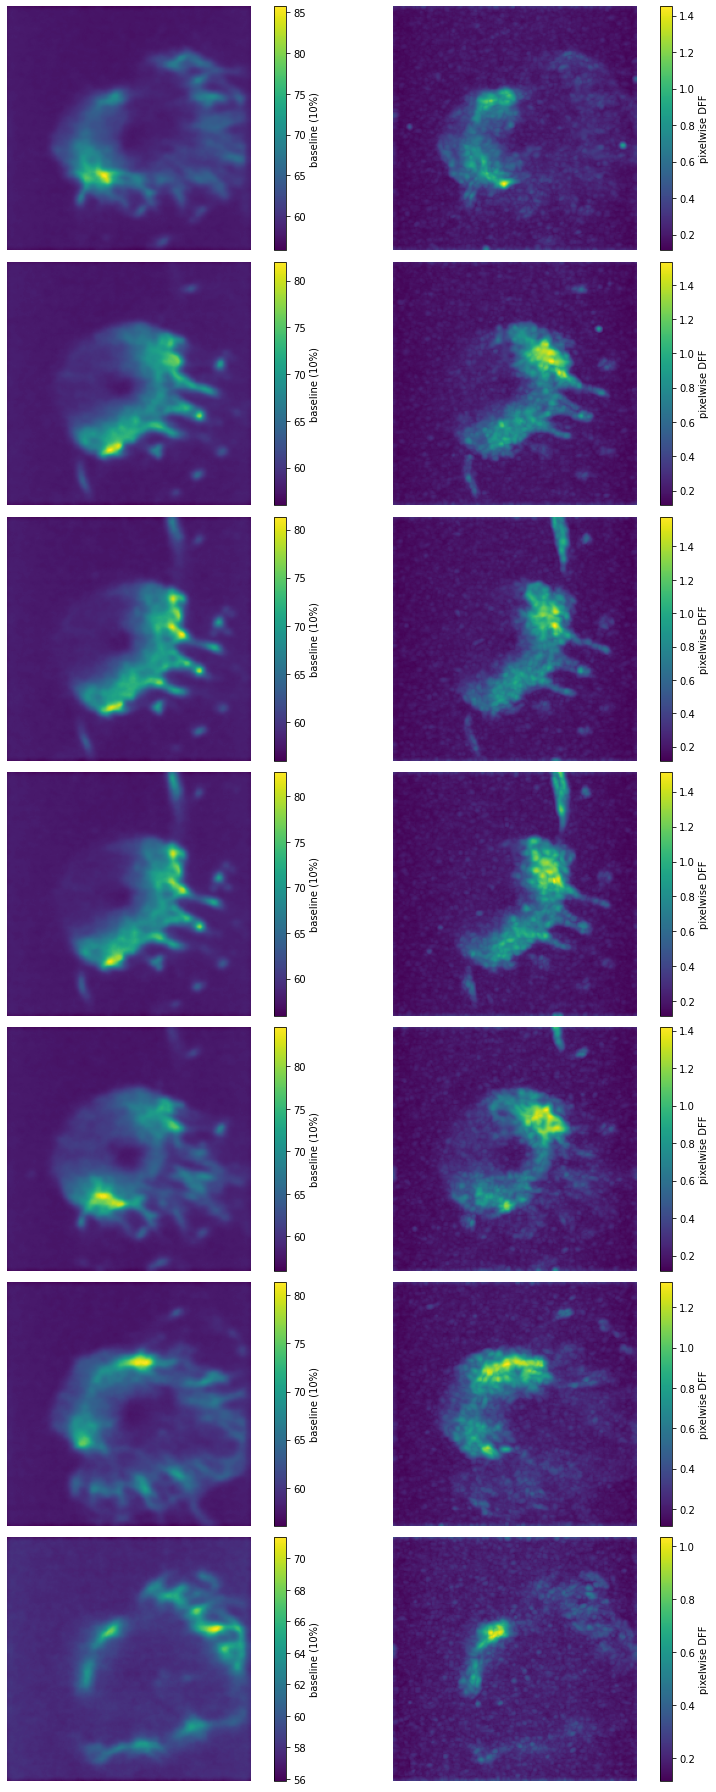

In [44]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2,figsize=(12,25))
for i in range(stack4dMC["planes [µm]"].size):
    cb = ax[i,0].imshow(stackF0[i,:,:],cmap='viridis',origin='upper')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,0], label='baseline ({}%)'.format(baseLinePercent))
    ax[i,0].axis('off')
    
    cb = ax[i,1].imshow(np.max(dffStack4dMC[:,i,:,:],axis=0),cmap='viridis',origin='upper')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,1], label='pixelwise DFF')
    ax[i,1].axis('off')
    fig.tight_layout()

In [155]:
#viewerdff1 = napari.view_image(dffStack4dMC)

#### (2) Define regions on which to perform clustering
Mark the area that should be considered with the napari labeling tool in a layer named "mask".

(a) Single plane mask for max projection

In [ ]:
viewer = napari.view_image(refImgFilt)

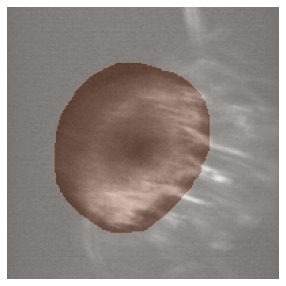

In [32]:
# you can draw a mask:
mask = viewer.layers["mask"]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r', vmin=0, origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.3)
fig.savefig(saveDir+sep+'_'.join(['mask',genotype, region, flyID, age, condition, trial])+'.pdf')

(b) 3D mask for volume processing

In [33]:
refStack = stack4dMC[0,:,:,:]
for i in range(stack4dMC["planes [µm]"].size):
    refStack[i,:,:] = stack4dMC[:,i,:,:].mean(axis=0)
    
viewer3D = napari.view_image(refStack)

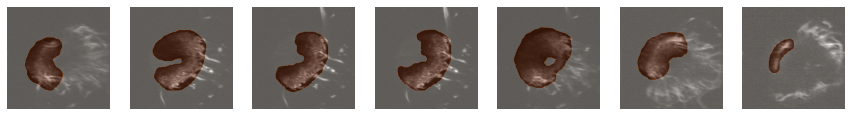

In [34]:
mask3D = viewer3D.layers["mask"]

fig, ax = plt.subplots(1,stack4dMC["planes [µm]"].size, figsize=(15,4))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i].imshow(refStack[i,:,:],cmap='Greys_r',origin='lower')  
    ax[i].axis('off');
    ax[i].imshow(mask3D.data[i,:,:], cmap='Oranges', alpha=0.35)
    
fig.savefig(saveDir+sep+'_'.join(['mask3D',genotype, region, flyID, age, condition, trial])+'.pdf')

#### (3) Perform clustering on pixels in mask

TODO: Check time axis generatiton

In [45]:
# Settings
from sklearn.cluster import KMeans

nclst = 9 # 4 for FBt

One plane

In [77]:
toClust = dffStackMC[:,mask.data>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

KMeans(n_clusters=9)

In [78]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [79]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

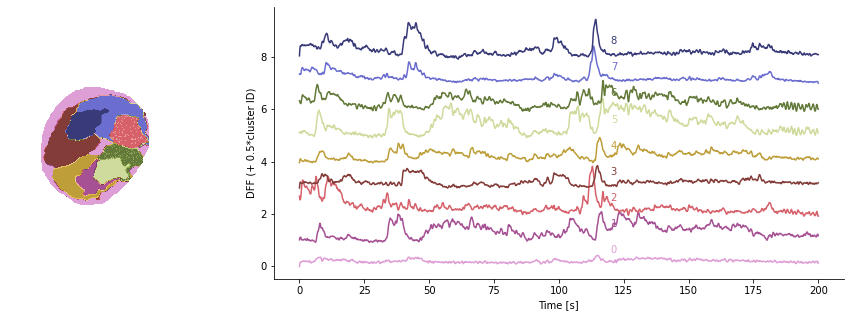

In [80]:
kmlabsImg = np.nan*np.ones(mask.data.shape)

kmlabsImg[mask.data>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

cluster: 0 	 meanpos: 105.0
cluster: 1 	 meanpos: 59.0
cluster: 2 	 meanpos: 110.0
cluster: 3 	 meanpos: 97.0
cluster: 4 	 meanpos: 63.0
cluster: 5 	 meanpos: 71.0
cluster: 6 	 meanpos: 86.0
cluster: 7 	 meanpos: 134.0
cluster: 8 	 meanpos: 120.0


<ipython-input-82-82e2c088d37c>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')


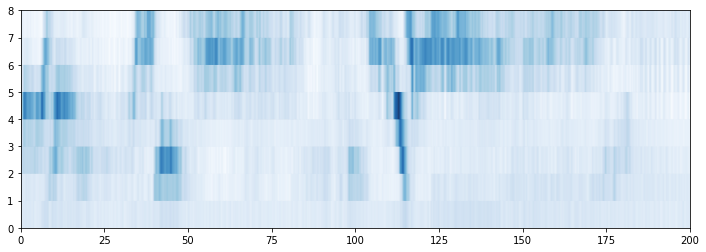

In [82]:
ypos = np.repeat(np.arange(mask.data.shape[0]),mask.data.shape[1]).reshape(mask.data.shape)
yPosClust = np.zeros(nclst)
for i in range(nclst):
    yPosClust[i] = mask.data.shape[0]-np.median(ypos[kmlabsImg==i])
    print('cluster: {} \t meanpos: {}'.format(i,yPosClust[i]))
    
centroidPerm = [0,3,8,7,2,6,5,1,4]#np.argsort(yPosClust)#
centroids2Plot = centroids[centroidPerm,:]

fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}_DFFreordered'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

Volume

In [53]:
nclst = 9 #5
toClust = dffStack4dMC[:,mask3D.data>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

KMeans(n_clusters=9)

In [54]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [55]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

<ipython-input-69-7707e3f2394e>:22: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


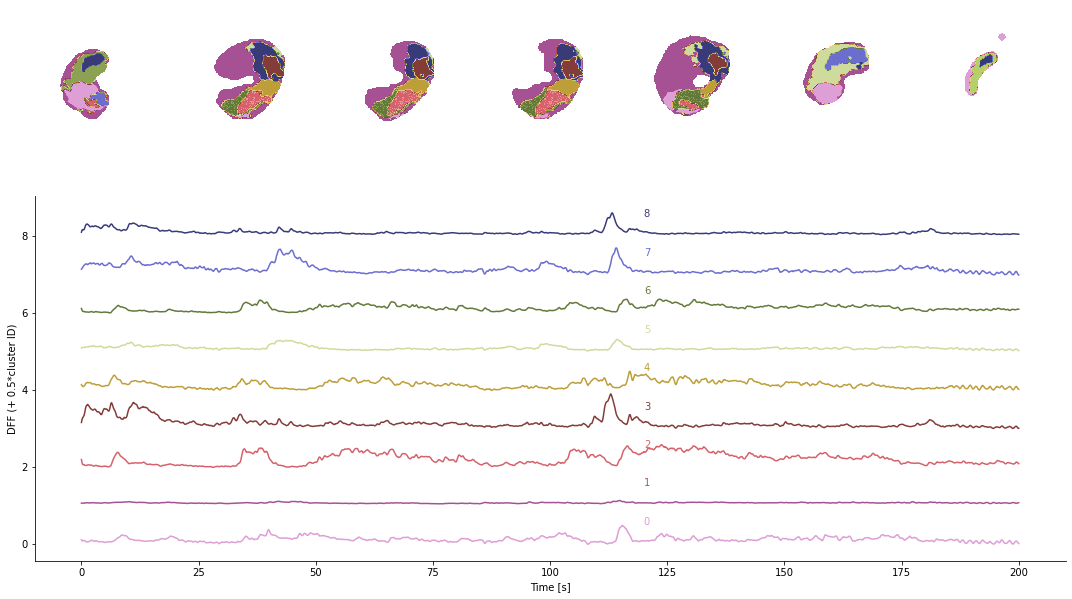

In [69]:
kmlabsImg = np.nan*np.ones(mask3D.data.shape)

kmlabsImg[mask3D.data>0] = kmlabs

fig = plt.figure(constrained_layout=True,figsize=(15,10))
#import matplotlib.gridspec as gridspec
gs  = fig.add_gridspec(2,stack4dMC["planes [µm]"].size)

for p in range(stack4dMC["planes [µm]"].size):
    ax = fig.add_subplot(gs[0,p])
    ax.imshow(kmlabsImg[p,:,:],cmap=myClstMap,origin='upper')
    ax.axis('off')

ax = fig.add_subplot(gs[1,:])
for i in range(nclst):
    ax.plot(time,centroids[i]+i, color=clstCMap.to_rgba(i+1))
    ax.text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
ax.set_xlabel('Time [s]')
ax.set_ylabel('DFF (+ 0.5*cluster ID)')
#ax.set_ylim(0, 1+nclst)
myAxisTheme(ax)
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

<ipython-input-76-80d264603ce2>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')


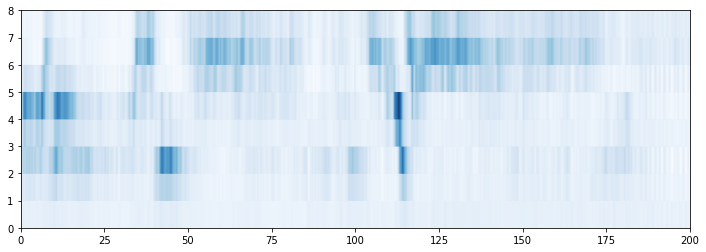

In [76]:
centroidPerm = [1,5,7,8,3,4,2,6,0]#np.argsort(yPosClust)#
centroids2Plot = centroids[centroidPerm,:]

fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}_DFFreordered'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

## Load in position data

In [440]:
posDataMat = rawTiff[:-3]+'mat'
print(posDataMat)

GCaMP7f_x_SS96_f02_7-8d_clutterWGroundAndCyli_00004.mat


In [441]:
matstruct = sio.loadmat(dataDir+sep+posDataMat)
posDat = matstruct['positionDat']

In [442]:
print('For each loged time point, the following parameters are reported:')
print(posDat[0,][0].dtype)

For each loged time point, the following parameters are reported:
[('t', 'O'), ('OffsetRot', 'O'), ('OffsetFor', 'O'), ('OffsetLat', 'O'), ('dx0', 'O'), ('dx1', 'O'), ('dy0', 'O'), ('dy1', 'O'), ('closed', 'O'), ('direction', 'O'), ('trans', 'O'), ('olgain', 'O'), ('clgain', 'O'), ('exType', 'O'), ('tFrameGrab', 'O'), ('tVR', 'O')]


In [443]:
tmtime = np.ndarray.flatten(posDat[0,0][0])
print(len(tmtime))

osRot = np.ndarray.flatten(posDat[0,0][1])
osFwd = np.ndarray.flatten(posDat[0,0][2])
osLat = np.ndarray.flatten(posDat[0,0][3])

dx0 = np.ndarray.flatten(posDat[0,0][4])
dx1 = np.ndarray.flatten(posDat[0,0][5])
dy0 = np.ndarray.flatten(posDat[0,0][6])
dy1 = np.ndarray.flatten(posDat[0,0][7])

tFrameGrab = np.ndarray.flatten(posDat[0,0][14][0])
print(len(tFrameGrab))
tVR = np.ndarray.flatten(posDat[0,0][15][0])
print(len(tVR))

29513
21248
61896


In [444]:
minFG = np.floor(np.where(tFrameGrab >= tVR[0])[0][0]/fpv)
maxFG = np.round(len(tFrameGrab)/fpv)
FG = (int(minFG), int(maxFG))

In [445]:
def interpFrames(rawDat, FG, fpv, time, framegrab, tVR):

    interpDat = np.zeros((FG[1]-FG[0], 1))
    
    for i in range(FG[0],FG[1]):
        
        iMatch = np.where( time >= ( time[0] + (framegrab[(i-1)*fpv+1] - tVR[0])/10000 ) )[0][0]
        interpDat[i - FG[0]] = rawDat[iMatch]
    
    return interpDat

In [446]:
timeMatched = tFrameGrab[0::fpv]/10000
timeMatched = timeMatched[FG[0]:FG[1]]
print(len(timeMatched))

tmtimeMatch = np.ndarray.flatten(interpFrames(tmtime,FG, fpv, tmtime, tFrameGrab, tVR)) 
osRotMatch = np.ndarray.flatten(interpFrames(osRot,FG, fpv, tmtime, tFrameGrab, tVR))
osFwdMatch = np.ndarray.flatten(interpFrames(osFwd,FG, fpv, tmtime, tFrameGrab, tVR))
osLatMatch = np.ndarray.flatten(interpFrames(osLat,FG, fpv, tmtime, tFrameGrab, tVR))

dx0Match = np.ndarray.flatten(interpFrames(dx0,FG, fpv, tmtime, tFrameGrab, tVR))
dx1Match = np.ndarray.flatten(interpFrames(dx1,FG, fpv, tmtime, tFrameGrab, tVR))
dy0Match = np.ndarray.flatten(interpFrames(dy0,FG, fpv, tmtime, tFrameGrab, tVR))
dy1Match = np.ndarray.flatten(interpFrames(dy1,FG, fpv, tmtime, tFrameGrab, tVR))

1755


In [447]:
vFwdMatched = np.hstack((0,abs(np.diff(osFwdMatch))/np.diff(timeMatched)))
#vFwdMatched[vFwdMatched>2] = np.nan

vTransMatched = np.hypot(osFwdMatch, osLatMatch)
vTransMatched = np.hstack((0,abs(np.diff(vTransMatched))/np.diff(timeMatched)))

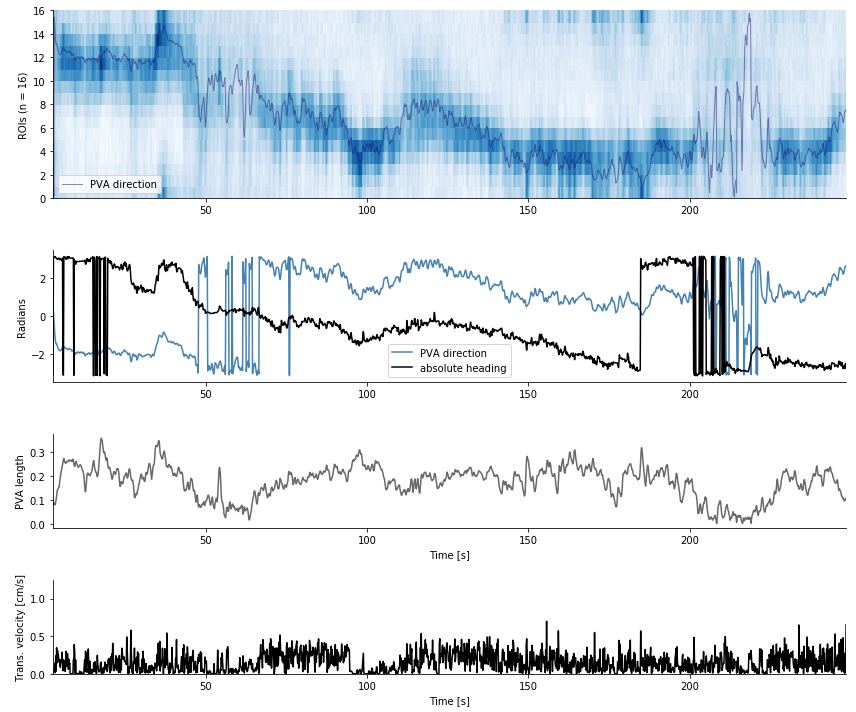

In [448]:
EBtracesMatched = EBtracesFilt[:,FG[0]:FG[1]]
pvaRoiMatched = pvaRoi[FG[0]:FG[1]]
pvaRadMatched = pvaRad[FG[0]:FG[1]]
pvaLenMatched = pvaLen[FG[0]:FG[1]]

from roiVisualization import myAxisTheme

fig, axs = plt.subplots(4,1, figsize=(12,10),gridspec_kw={'height_ratios':[1,0.7, 0.5, 0.5]})
cax = axs[0].pcolor(timeMatched,np.arange(0,nsteps+1),EBtracesMatched,cmap='Blues', edgecolors='face')
axs[0].set_ylabel('\nROIs (n = {0})'.format(nsteps))
axs[0].plot(timeMatched,pvaRoiMatched,'-', color='midnightblue', linewidth=1, alpha=0.5, label='PVA direction')
axs[0].legend()

axs[1].plot(timeMatched,pvaRadMatched,color='steelblue', label='PVA direction')
axs[1].plot(timeMatched,osRotMatch*np.pi/180.,color='black', label='absolute heading')
axs[1].set_ylabel('Radians')
axs[1].legend()

axs[2].plot(timeMatched,pvaLenMatched,color='dimgrey', label='PVA length')
axs[2].set_ylabel('PVA length')
axs[2].set_xlabel('Time [s]')

axs[3].plot(timeMatched,vTransMatched,color='black', label='transl. velocity')
axs[3].set_ylim(0,1.25)
axs[3].set_ylabel('Trans. velocity [cm/s]')
axs[3].set_xlabel('Time [s]')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlim(timeMatched[0],timeMatched[-1])
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['DFF-PVA-heading-fwdvelo', genotype, region, flyID, age, condition, trial, date])+'.pdf')

#### Relate PVA to relative heading (w.r.t. local landmark)

In [449]:
LMcoords = (0,0)

In [450]:
def dotproduct2d(a, b):
    # 2D dot product
    return a[0, :]*b[0, :] + a[1, :]*b[1, :]


def veclength2d(vec):
    return np.sqrt(vec[0, :]**2 + vec[1, :]**2)


def relationToObject(time, xPos, yPos, angle, objLocation):
    # Assumes only one object, thus in case of fly VR one needs to use the projected xPosMA

    # Vector to object location
    objDirection = np.vstack((objLocation[0]-xPos, objLocation[1]-yPos))

    objDistance = np.hypot(objLocation[0]-xPos, objLocation[1]-yPos)

    # Fly orientation vector
    flyDirection = np.vstack((np.cos(angle), np.sin(angle)))

    # Angle to object relative from fly's orientation
    lenFlyVec = np.hypot(flyDirection[0, :], flyDirection[1, :])
    lenObjVec = np.hypot(objDirection[0, :], objDirection[1, :])

    gamma = np.arccos(dotproduct2d(flyDirection, objDirection) / (lenFlyVec * lenObjVec))

    gammaFull = np.arctan2(flyDirection[1, :], flyDirection[0, :])-np.arctan2(objDirection[1, :], objDirection[0, :])
    gammaFull[gammaFull < 0] += 2 * np.pi
    gammaFull[gammaFull > np.pi] -= 2 * np.pi

    gammaV = np.hstack((np.diff(gamma)/np.diff(time), 0))

    return objDirection, objDistance, gammaFull, gamma, gammaV

In [451]:
_, LMdist, gamma, gammahalf, _ = relationToObject(tmtimeMatch, osFwdMatch, osLatMatch, osRotMatch*np.pi/180., LMcoords)

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [460]:
# Change offset of PVA to match either abs. or rel. heading trace
PVAst = 0.2#-0.8
pvaPlot = np.mod((np.unwrap(pvaRadMatched,np.pi) + PVAst), np.pi*2) - np.pi

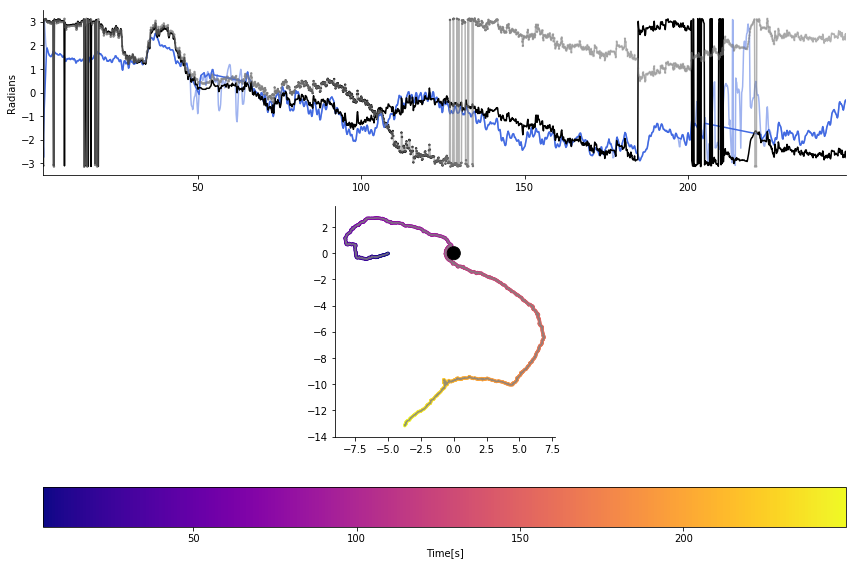

In [461]:
localLM = True
pvaLenTH = 0.1

fig, axs = plt.subplots(2,1, figsize=(12,8),gridspec_kw={'height_ratios':[1,2]})
axs[0].plot(timeMatched,pvaPlot,color='royalblue', alpha=0.5)
axs[0].plot(timeMatched[pvaLenMatched>pvaLenTH],pvaPlot[pvaLenMatched>pvaLenTH],color='royalblue', alpha=1, label='PVA direction')
#axs[0].plot(timeMatched,pvaRadMatched,color='royalblue', alpha=1, label='PVA direction')
#axs[0].scatter(timeMatched,pvaRadMatched, s=5, c=tmtimeMatch, cmap='plasma')
axs[0].plot(timeMatched,osRotMatch*np.pi/180.,color='black', label='absolute heading')
if localLM:
    axs[0].plot(timeMatched,gamma,color='grey',alpha=0.6, label='relative (LM) heading')
    axs[0].scatter(timeMatched,gamma,s=2, c=LMdist, cmap='Greys_r')
axs[0].set_ylabel('Radians')
#axs[0].legend()
axs[0].set_xlim(timeMatched[0],timeMatched[-1])

#cb = axs[1].scatter(osFwdMatch, osLatMatch, s=5, c=osRotMatch*np.pi/180, cmap='hsv')
axs[1].plot(osFwdMatch, osLatMatch,color='grey', alpha=0.8)
cb = axs[1].scatter(osFwdMatch, osLatMatch, s=5, c=tmtimeMatch, cmap='plasma')
plt.colorbar(cb, ax=axs[1], orientation='horizontal', label='Time[s]')
axs[1].set_aspect('equal')

if localLM:
    # add landmark
    from matplotlib.patches import Circle
    circle = Circle((0, 0), 0.5, color='black')
    axs[1].add_artist(circle)
    #axs[1].set_xlim(-10,5)

for ax in axs:
    myAxisTheme(ax)
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['PVA-absHead-relHead-traj',genotype, region, flyID, age, condition, trial, date])+'.pdf')